In [1]:
#Written by Jeb Weaver 2022

#Created by following TensorFlow Orginization Image Classification Tutorial
#TensorFlow Team. Image Classification. TensorFlow Tutorials. Retrieved December 19, 2022, 
#from https://www.tensorflow.org/tutorials/images/classification

In [21]:
#This program creates, trains, and tests a convolutional nerual network image classifier. 
#The images are close-up shots of woodgrain which are classified according to species.

#Dataset structure: 
#Root Folder ("Woodgrain")
# --> Folder for each class of images ("RedCedar", "WhiteCedar", "Oak", "Cherry")

#Keras will determine class labels from the names of image folders.
#New classes can be added simply by creating a labeled folder containing images for that class.

In [2]:
#Import libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

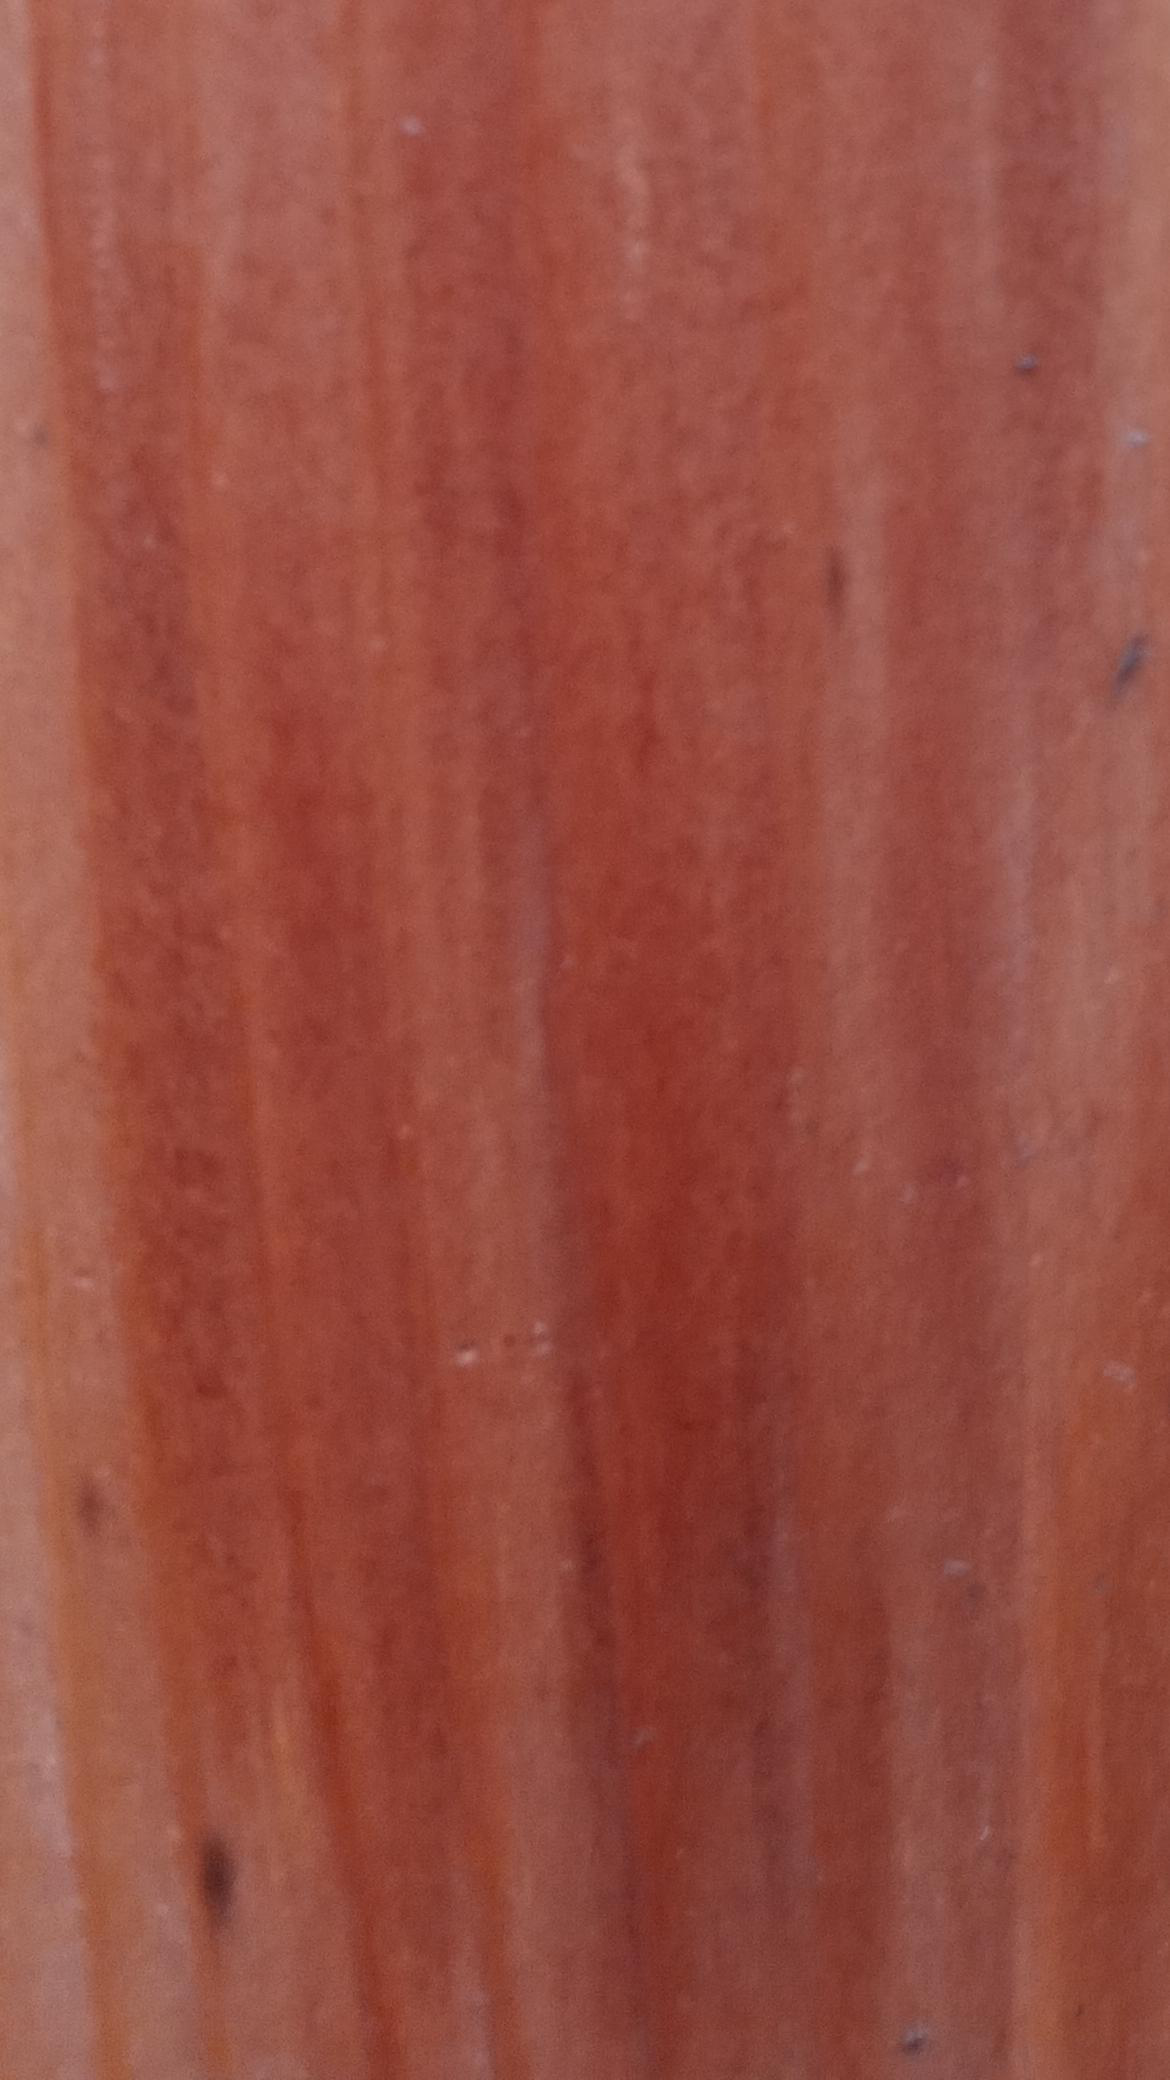

In [3]:
import pathlib

#Locate the images
imagePath = r"C:\Users\jebwe\Desktop\Woodgrain"

#Convert file path into expected format
imagePath = pathlib.Path(imagePath)

#Test the file path by showing an image
whitecedar = list(imagePath.glob('WhiteCedar/*'))
PIL.Image.open(str(whitecedar[1]))

In [4]:
#Model Parameters
batch_size = 32

img_height = 360

img_width = 360

In [5]:
#Create training dataset using keras function
trainSet = tf.keras.utils.image_dataset_from_directory(
  imagePath,
  validation_split=0.2, #Remove 20% of images from this set (training)
  subset="training", #label for this set
  seed=123, #Ensure consistant
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1152 files belonging to 3 classes.
Using 922 files for training.


In [6]:
#Create validation dataset using keras function
validationSet = tf.keras.utils.image_dataset_from_directory(
  imagePath,
  validation_split=0.2, #Keep 20% of images for this set (validation)
  subset="validation", #label for this set
  seed=123, #Ensure consistant
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1152 files belonging to 3 classes.
Using 230 files for validation.


In [7]:
#Get class names from the training set (Folder names)
class_names = trainSet.class_names
print(class_names)

['Oak', 'RedCedar', 'WhiteCedar']


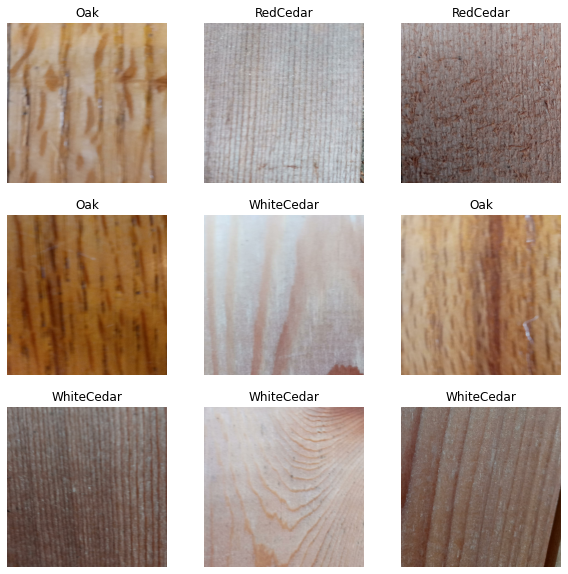

In [8]:
#Plot a few images to verify training set importation

plt.figure(figsize=(10, 10))
for images, labels in trainSet.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1) #Add images into 3x3 grid at location i+1
        plt.imshow(images[i].numpy().astype("uint8")) #8bit per channel colors
        plt.title(class_names[labels[i]]) #labels from class names in previous cell
        plt.axis("off")

In [9]:
#Create caches for training and validation data

AUTOTUNE = tf.data.AUTOTUNE #Autotune will select the number of images to prefetch before processing

trainSet = trainSet.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #cache training images, shuffle filenames
validationSet = validationSet.cache().prefetch(buffer_size=AUTOTUNE) #cache validation images

In [10]:
#Data augmentation

#Create sequential augmentation model to be used as input layer in full model
augmentLayer = keras.Sequential()
augmentLayer.add(layers.RandomFlip("horizontal",seed=123,input_shape=(img_height,img_width,3)))
augmentLayer.add(layers.RandomZoom(0.2,seed = 123))
augmentLayer.add(layers.RandomRotation(0.2, seed = 123))

#Comment out layer below if using FilterVisualizer Program
augmentLayer.add(layers.RandomContrast((1,1.75), seed = 123))

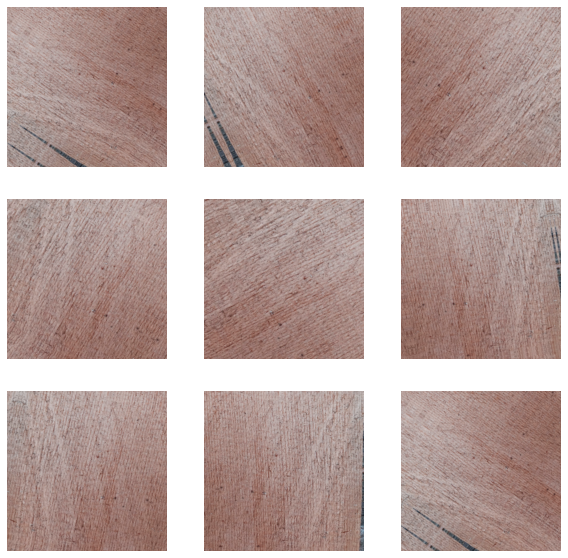

In [11]:
#Verify augmentation by displaying a few augmented images
plt.figure(figsize=(10, 10))
for images, _ in trainSet.take(1):
    for i in range(9):
        augmented_images = augmentLayer(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [12]:
#Create the model
from tensorflow.keras import regularizers

num_classes = len(class_names)

#Sequential model of linear layers
model = keras.Sequential()

#Data augmentation layer
model.add(augmentLayer)

#Transform 8-bit integer colors to decimal format
model.add(layers.Rescaling(1./255))

#Convolution layer 1
model.add(layers.Conv2D(16, 3, padding='same', name="conv1",kernel_regularizer=regularizers.l2(l=0.01)))
#model.add(layers.BatchNormalization(axis=-1,momentum=.99,epsilon=.001))
model.add(layers.Activation(activation='relu'))
#model.add(layers.AveragePooling2D((2,2)))
model.add(layers.MaxPooling2D((2,2)))

#Spatial dropout layer
model.add(layers.SpatialDropout2D(.2))

#Convolution layer 2
model.add(layers.Conv2D(32, 3, padding='same', name='conv2',kernel_regularizer=regularizers.l2(l=0.01)))
#model.add(layers.BatchNormalization(axis=-1,momentum=.99,epsilon=.001))
model.add(layers.Activation(activation='relu'))
#model.add(layers.AveragePooling2D((2,2)))
model.add(layers.MaxPooling2D((2,2)))


#Convolution layer 3
model.add(layers.Conv2D(64, 3, padding='same', name='conv3',kernel_regularizer=regularizers.l2(l=0.01)))
#model.add(layers.BatchNormalization(axis=-1,momentum=.99,epsilon=.001))
model.add(layers.Activation(activation='relu'))
#model.add(layers.AveragePooling2D((2,2)))
model.add(layers.MaxPooling2D((2,2)))

#Convolution layer 4
model.add(layers.Conv2D(64, 3, padding='same', name='conv4',kernel_regularizer=regularizers.l2(l=0.01)))
#model.add(layers.BatchNormalization(axis=-1,momentum=.99,epsilon=.001))
model.add(layers.Activation(activation='relu'))
#model.add(layers.AveragePooling2D((2,2)))
model.add(layers.MaxPooling2D((2,2)))

#Flatten data dimension for input to dense layer
model.add(layers.Flatten())

#Dense layer - changed to 64
model.add(layers.Dense(128, activation='relu'))

#Dropout layer
model.add(layers.Dropout(0.2))

#Test normalization here
#model.add(layers.BatchNormalization(axis=-1,momentum=.99,epsilon=.001))

#Output layer
model.add(layers.Dense(num_classes, name="outputs"))

In [13]:
#Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
#Summary of model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 360, 360, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 360, 360, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 360, 360, 16)      448       
                                                                 
 activation (Activation)     (None, 360, 360, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 180, 180, 16)     0         
 )                                                               
                                                                 
 spatial_dropout2d (SpatialD  (None, 180, 180, 16)     0         
 ropout2D)                                            

In [15]:
#Fit the new model with, currently, 15 epochs
epochs = 30
history = model.fit(
  trainSet,
  validation_data=validationSet,
  epochs=epochs,
  shuffle = True   
)

Epoch 1/30
29/29 [==============================] - 47s 1s/step - loss: 2.4511 - accuracy: 0.4132 - val_loss: 1.5642 - val_accuracy: 0.4130
Epoch 2/30
29/29 [==============================] - 42s 1s/step - loss: 1.4815 - accuracy: 0.4740 - val_loss: 1.4144 - val_accuracy: 0.5609
Epoch 3/30
29/29 [==============================] - 42s 1s/step - loss: 1.3406 - accuracy: 0.5466 - val_loss: 1.1691 - val_accuracy: 0.5739
Epoch 4/30
29/29 [==============================] - 41s 1s/step - loss: 1.2219 - accuracy: 0.5759 - val_loss: 1.0990 - val_accuracy: 0.5696
Epoch 5/30
29/29 [==============================] - 42s 1s/step - loss: 1.1252 - accuracy: 0.6247 - val_loss: 1.0463 - val_accuracy: 0.5783
Epoch 6/30
29/29 [==============================] - 45s 2s/step - loss: 1.0903 - accuracy: 0.6139 - val_loss: 0.9540 - val_accuracy: 0.7174
Epoch 7/30
29/29 [==============================] - 51s 2s/step - loss: 1.0307 - accuracy: 0.6638 - val_loss: 0.9293 - val_accuracy: 0.7565
Epoch 8/30
29/29 [==

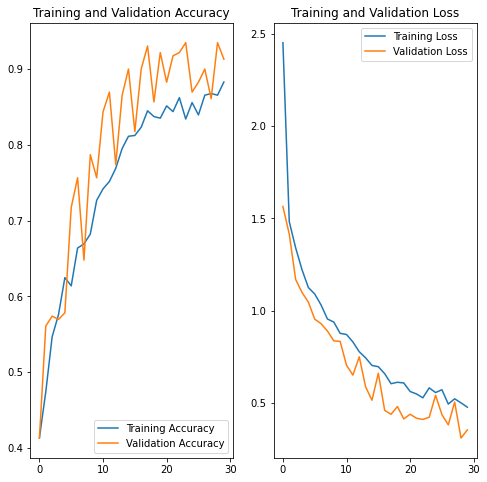

In [16]:
#Plot resutls of new model

acc = history.history['accuracy'] #get the training accuracy for the fit model
val_acc = history.history['val_accuracy'] #get the validation accuracy for the fit model

loss = history.history['loss'] #get the training loss for the fit model
val_loss = history.history['val_loss'] #get the validation loss for the fit model

epochs_range = range(epochs) #To be used as horizontal axis

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1) #Place the first figure in the 1 by 2 grid
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2) #Place the first figure in the 1 by 2 grid
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [17]:
#Test of Oak holdout set

#Locate the images
imagePath = r"C:\Users\jebwe\Desktop\Holdout"

#Convert file path into expected format
imagePath = pathlib.Path(imagePath)

#Test the file path by showing an image
toTest = list(imagePath.glob('Oak/*'))

#Go through all images of this class in the holdout set
for i in range(len(toTest)):
    
    #Open image with PIL
    img = PIL.Image.open(str(toTest[i]))
    
    #Match size to classifier size
    size = (img_width,img_height)
    img = img.resize(size)
    
    #Convert image to pixel array format
    img_array = tf.keras.utils.img_to_array(img)
    
    #Classifier expects tensor of specific size
    img_array = tf.expand_dims(img_array, 0)

    #Use the model to predict on this image
    predictions = model.predict(img_array)
    
    #Get the score for this image
    score = tf.nn.softmax(predictions[0])

    #Display the result
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

1/1 [==============================] - 0s 141ms/step
This image most likely belongs to Oak with a 99.08 percent confidence.
1/1 [==============================] - 0s 31ms/step
This image most likely belongs to Oak with a 81.91 percent confidence.
1/1 [==============================] - 0s 31ms/step
This image most likely belongs to Oak with a 99.31 percent confidence.
1/1 [==============================] - 0s 36ms/step
This image most likely belongs to Oak with a 97.63 percent confidence.
1/1 [==============================] - 0s 32ms/step
This image most likely belongs to Oak with a 99.29 percent confidence.
1/1 [==============================] - 0s 47ms/step
This image most likely belongs to Oak with a 98.97 percent confidence.
1/1 [==============================] - 0s 47ms/step
This image most likely belongs to Oak with a 99.28 percent confidence.
1/1 [==============================] - 0s 31ms/step
This image most likely belongs to Oak with a 97.14 percent confidence.
1/1 [==========

In [18]:
#Test of Red Cedar holdout set

#Locate the images
imagePath = r"C:\Users\jebwe\Desktop\Holdout"

#Convert file path into expected format
imagePath = pathlib.Path(imagePath)

#Test the file path by showing an image
toTest = list(imagePath.glob('RedCedar/*'))

#Go through all images of this class in the holdout set
for i in range(len(toTest)):
    
    #Open image with PIL
    img = PIL.Image.open(str(toTest[i]))
    
    #Match size to classifier size
    size = (img_width,img_height)
    img = img.resize(size)
    
    #Convert image to pixel array format
    img_array = tf.keras.utils.img_to_array(img)
    
    #Classifier expects tensor of specific size
    img_array = tf.expand_dims(img_array, 0)

    #Use the model to predict on this image
    predictions = model.predict(img_array)
    
    #Get the score for this image
    score = tf.nn.softmax(predictions[0])

    #Display the result
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

1/1 [==============================] - 0s 32ms/step
This image most likely belongs to Oak with a 84.38 percent confidence.
1/1 [==============================] - 0s 47ms/step
This image most likely belongs to Oak with a 83.05 percent confidence.
1/1 [==============================] - 0s 31ms/step
This image most likely belongs to RedCedar with a 93.51 percent confidence.
1/1 [==============================] - 0s 31ms/step
This image most likely belongs to RedCedar with a 90.29 percent confidence.
1/1 [==============================] - 0s 47ms/step
This image most likely belongs to Oak with a 96.57 percent confidence.
1/1 [==============================] - 0s 47ms/step
This image most likely belongs to Oak with a 95.27 percent confidence.
1/1 [==============================] - 0s 47ms/step
This image most likely belongs to RedCedar with a 72.12 percent confidence.
1/1 [==============================] - 0s 47ms/step
This image most likely belongs to RedCedar with a 94.95 percent confiden

In [19]:
#Test of White Ceder holdout set

#Locate the images
imagePath = r"C:\Users\jebwe\Desktop\Holdout"

#Convert file path into expected format
imagePath = pathlib.Path(imagePath)

#Test the file path by showing an image
toTest = list(imagePath.glob('WhiteCedar/*'))

#Go through all images of this class in the holdout set
for i in range(len(toTest)):
    
    #Open image with PIL
    img = PIL.Image.open(str(toTest[i]))
    
    #Match size to classifier size
    size = (img_width,img_height)
    img = img.resize(size)
    
    #Convert image to pixel array format
    img_array = tf.keras.utils.img_to_array(img)
    
    #Classifier expects tensor of specific size
    img_array = tf.expand_dims(img_array, 0)

    #Use the model to predict on this image
    predictions = model.predict(img_array)
    
    #Get the score for this image
    score = tf.nn.softmax(predictions[0])

    #Display the result
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

1/1 [==============================] - 0s 47ms/step
This image most likely belongs to RedCedar with a 56.59 percent confidence.
1/1 [==============================] - 0s 31ms/step
This image most likely belongs to WhiteCedar with a 92.86 percent confidence.
1/1 [==============================] - 0s 47ms/step
This image most likely belongs to WhiteCedar with a 76.05 percent confidence.
1/1 [==============================] - 0s 47ms/step
This image most likely belongs to WhiteCedar with a 86.85 percent confidence.
1/1 [==============================] - 0s 31ms/step
This image most likely belongs to WhiteCedar with a 77.27 percent confidence.
1/1 [==============================] - 0s 44ms/step
This image most likely belongs to WhiteCedar with a 94.42 percent confidence.
1/1 [==============================] - 0s 47ms/step
This image most likely belongs to WhiteCedar with a 74.56 percent confidence.
1/1 [==============================] - 0s 32ms/step
This image most likely belongs to RedCed

In [20]:
#Save the trained model with weights for use in FilterVisualization
model.save('trainedModel.h5')